## Análise Comparativa das Simulações do Cenário 1

Este notebook carrega, analisa e compara os resultados de três simulações de gerenciamento de projeto geradas por diferentes modelos de IA. O objetivo é visualizar as diferenças nas estimativas de custo, prazo e impacto de eventos.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
pd.options.display.float_format = '{:,.2f}'.format

### 1. Carregamento e Preparação dos Dados

Carregamos os arquivos JSON de cada simulação e extraímos os dados relevantes da síntese final para uma estrutura padronizada.

In [8]:
def carregar_dados_simulacao(filepath, model_name):
    """Carrega um arquivo JSON de simulação e extrai os dados chave."""
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    sintese = data['sintese_final']['relatorio_final_projeto']
    
    # Lida com estruturas de JSON ligeiramente diferentes
    if 'custo' in sintese['analise_quantitativa_final']:
        quant_analise = sintese['analise_quantitativa_final']
        custo_plan = quant_analise['custo']['planejado_total']
        custo_real = quant_analise['custo']['realizado_total']
        desvio_custo = quant_analise['custo']['desvio_percentual']
        prazo_plan = quant_analise['prazo']['planejado_total_dias']
        prazo_real = quant_analise['prazo']['realizado_total_dias']
        desvio_prazo = quant_analise['prazo']['desvio_percentual']
    else:
        quant_analise = sintese['analise_quantitativa_final']
        custo_plan = quant_analise['custo_planejado_total']
        custo_real = quant_analise['custo_realizado_total']
        desvio_custo = quant_analise['desvio_custo_percentual']
        prazo_plan = quant_analise['prazo_planejado_total_dias']
        prazo_real = quant_analise['prazo_realizado_total_dias']
        desvio_prazo = quant_analise['desvio_prazo_percentual']
        
    dados_gerais = {
        'Modelo': model_name,
        'Custo Planejado': custo_plan,
        'Custo Realizado': custo_real,
        'Desvio Custo (%)': desvio_custo,
        'Prazo Planejado (dias)': prazo_plan,
        'Prazo Realizado (dias)': prazo_real,
        'Desvio Prazo (%)': desvio_prazo
    }
    
    dados_eventos = []
    for evento in sintese['analise_de_impacto_eventos']:
        dados_eventos.append({
            'Modelo': model_name,
            'Evento': evento['evento'],
            'Impacto Custo': evento['impacto_quantitativo']['custo_adicional_estimado'],
            'Impacto Prazo (dias)': evento['impacto_quantitativo']['impacto_prazo_dias']
        })

    dados_sprints = []
    for sprint in data.get('resultados_por_sprint', []):
        dados_sprints.append({
            'Modelo': model_name,
            'Sprint ID': sprint['sprint_id'],
            'Custo da Sprint': sprint['total_sprint_cost'],
            'Dias da Sprint': sprint['total_sprint_days']
        })
        
    return dados_gerais, dados_eventos, dados_sprints

# Arquivos das simulações
files = {
    'Gemini 2.5 Pro': 'cenario1/resultado_simulacao_gemini-2.5-pro.json',
    'Gemini 2.0 Flash': 'cenario1/resultado_simulacao_gemini-2.0-flash.json',
    'Gemini 2.0 Flash Lite': 'cenario1/resultado_simulacao_gemini-2-0-flash-lite.json'
}

all_geral = []
all_eventos = []
all_sprints_data = []

for name, path in files.items():
    geral, eventos, sprints = carregar_dados_simulacao(path, name)
    all_geral.append(geral)
    all_eventos.extend(eventos)
    all_sprints_data.extend(sprints)

df_geral = pd.DataFrame(all_geral)
df_eventos = pd.DataFrame(all_eventos)
df_sprints = pd.DataFrame(all_sprints_data)

### 2. Tabela Comparativa dos Resultados Finais

A tabela abaixo resume os resultados consolidados de cada modelo, permitindo uma comparação direta dos desvios de custo e prazo.

In [3]:
df_geral.set_index('Modelo')

,Custo Planejado,Custo Realizado,Desvio Custo (%),Prazo Planejado (dias),Prazo Realizado (dias),Desvio Prazo (%)
Modelo,,,,,,
Gemini 2.5 Pro,"43,640.00","66,060.00",51.37,85.00,97.75,15.00
Gemini 2.0 Flash,"45,610.00","67,220.00",47.38,88.50,99.50,12.43
Gemini 2.0 Flash Lite,"53,690.00","70,200.00",30.75,105.00,113.20,7.81


### 3. Análise Gráfica de Custo e Prazo

Os gráficos de barras comparam os valores planejados e realizados para custo e prazo em cada simulação.

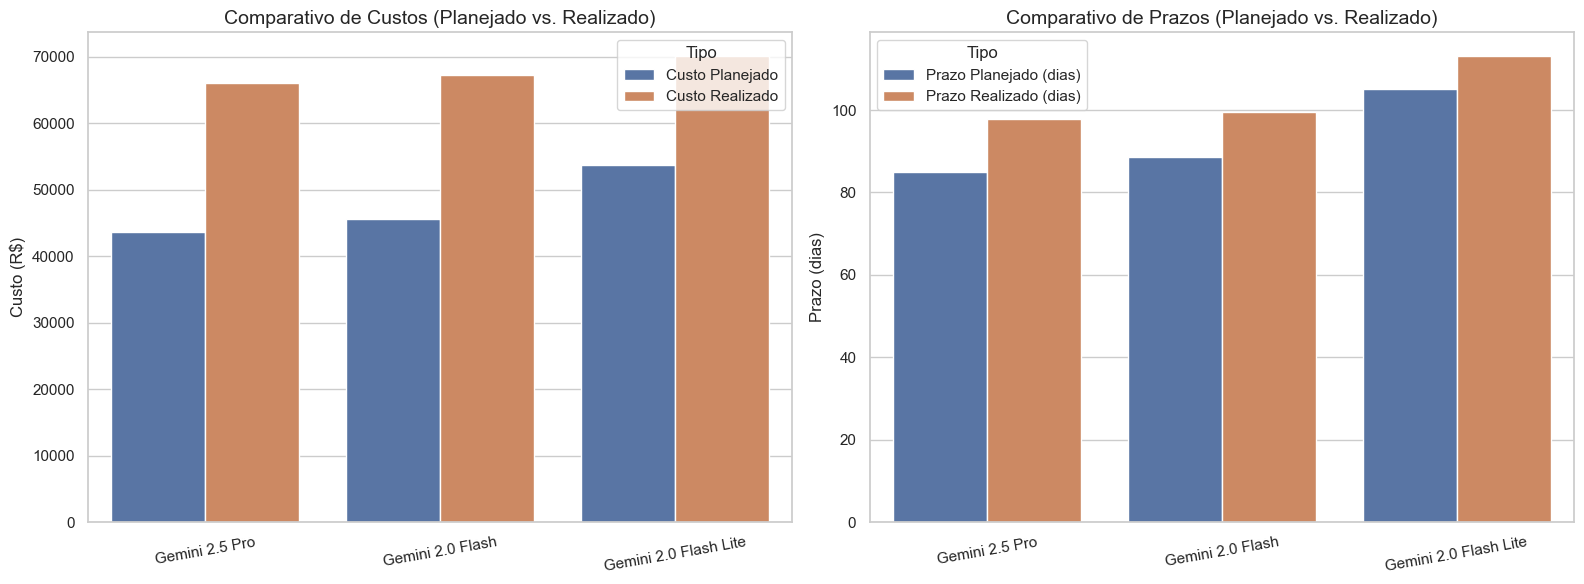

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de Custos
df_custo = df_geral[['Modelo', 'Custo Planejado', 'Custo Realizado']].melt('Modelo', var_name='Tipo', value_name='Valor')
sns.barplot(data=df_custo, x='Modelo', y='Valor', hue='Tipo', ax=axes[0])
axes[0].set_title('Comparativo de Custos (Planejado vs. Realizado)', fontsize=14)
axes[0].set_ylabel('Custo (R$)')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=10)

# Gráfico de Prazos
df_prazo = df_geral[['Modelo', 'Prazo Planejado (dias)', 'Prazo Realizado (dias)']].melt('Modelo', var_name='Tipo', value_name='Dias')
sns.barplot(data=df_prazo, x='Modelo', y='Dias', hue='Tipo', ax=axes[1])
axes[1].set_title('Comparativo de Prazos (Planejado vs. Realizado)', fontsize=14)
axes[1].set_ylabel('Prazo (dias)')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=10)

plt.tight_layout()
plt.show()

### 4. Análise de Impacto dos Eventos

Analisamos o impacto estimado (custo e prazo) de cada evento específico (saída e contratação) em cada uma das simulações.

In [5]:
df_eventos_pivot = df_eventos.pivot_table(
    index='Evento',
    columns='Modelo',
    values=['Impacto Custo', 'Impacto Prazo (dias)']
)
display(df_eventos_pivot)

Impacto Custo                        \
Modelo                                Gemini 2.0 Flash Gemini 2.0 Flash Lite   
Evento                                                                         
Contratação da Desenvolvedora 'Elisa'         2,650.00              2,650.00   
Saída da Desenvolvedora 'Carla'              18,960.00             13,860.00   

                                                     Impacto Prazo (dias)  \
Modelo                                Gemini 2.5 Pro     Gemini 2.0 Flash   
Evento                                                                      
Contratação da Desenvolvedora 'Elisa'       7,420.00                -4.00   
Saída da Desenvolvedora 'Carla'            15,000.00                15.00   

                                                                            
Modelo                                Gemini 2.0 Flash Lite Gemini 2.5 Pro  
Evento                                                                      
Contratação da Desenvolvedora 'Elisa'                 -4.00           1.75  
Saída da Desenvolvedora 'Carla'                       12.20          11.00

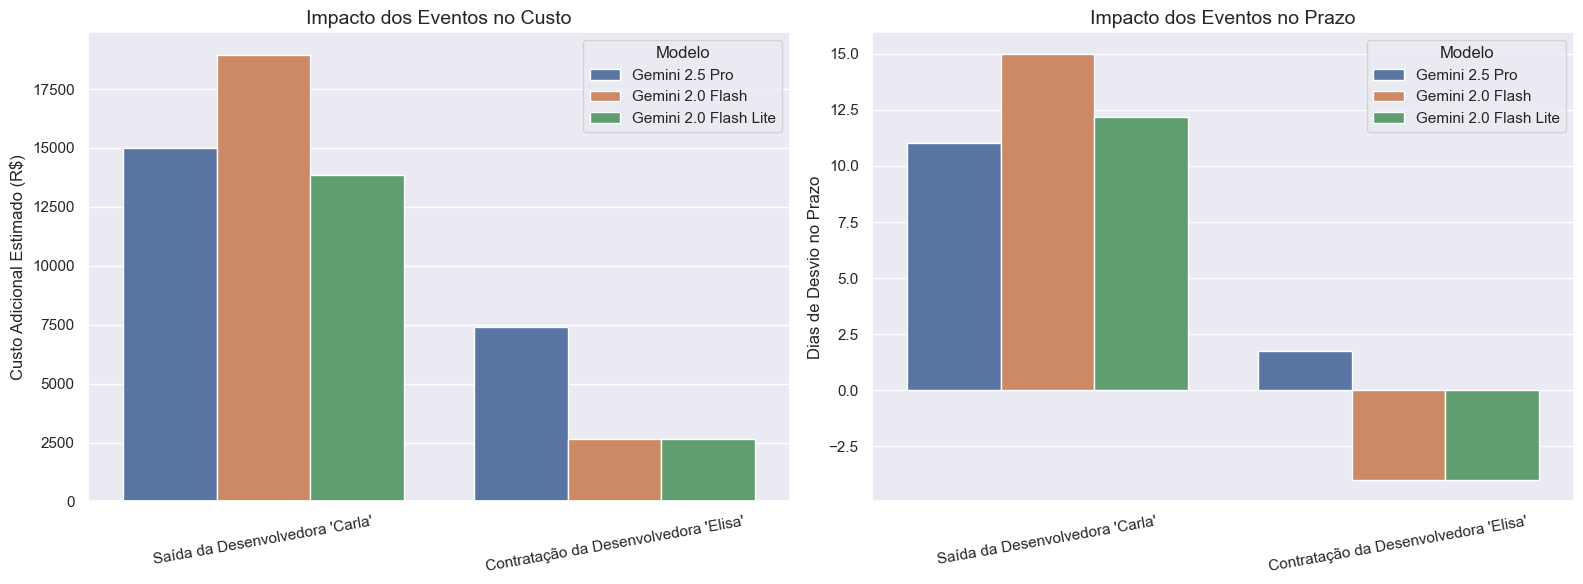

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Gráfico de Impacto no Custo
sns.barplot(data=df_eventos, x='Evento', y='Impacto Custo', hue='Modelo', ax=axes[0])
axes[0].set_title('Impacto dos Eventos no Custo', fontsize=14)
axes[0].set_ylabel('Custo Adicional Estimado (R$)')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=10)

# Gráfico de Impacto no Prazo
sns.barplot(data=df_eventos, x='Evento', y='Impacto Prazo (dias)', hue='Modelo', ax=axes[1])
axes[1].set_title('Impacto dos Eventos no Prazo', fontsize=14)
axes[1].set_ylabel('Dias de Desvio no Prazo')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=10)

plt.tight_layout()
plt.show()

### 5. Análise dos Custos e Prazos por Sprint

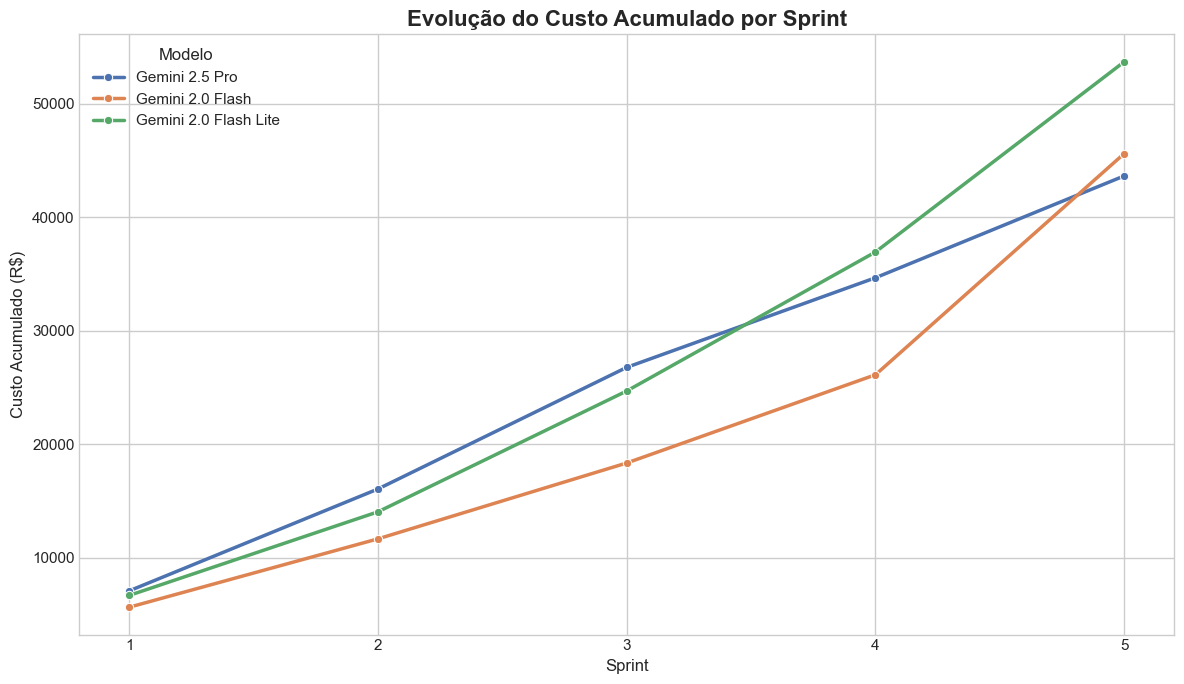

In [9]:
# Calcular o custo acumulado por modelo
df_sprints['Custo Acumulado'] = df_sprints.groupby('Modelo')['Custo da Sprint'].cumsum()

# Criar o gráfico de linha
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 7))

line_plot = sns.lineplot(
    data=df_sprints,
    x='Sprint ID',
    y='Custo Acumulado',
    hue='Modelo',
    marker='o',
    linewidth=2.5
)

# Configurar títulos e rótulos
plt.title('Evolução do Custo Acumulado por Sprint', fontsize=16, weight='bold')
plt.xlabel('Sprint', fontsize=12)
plt.ylabel('Custo Acumulado (R$)', fontsize=12)
plt.xticks(df_sprints['Sprint ID'].unique())
plt.legend(title='Modelo')
plt.tight_layout()

# Exibir o gráfico
plt.show()

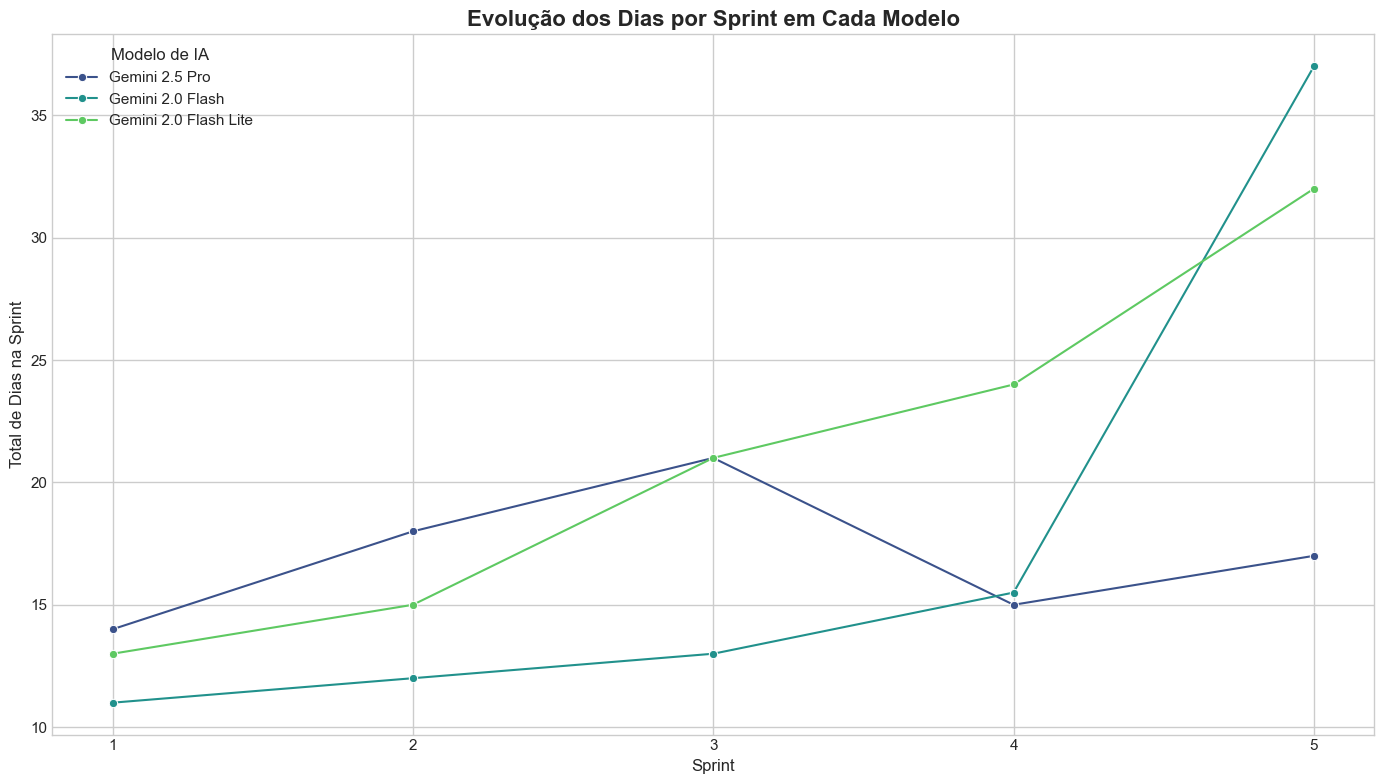

In [11]:
# Criando a figura e os eixos para o gráfico
plt.figure(figsize=(14, 8))

# Criando o gráfico de linha
line_plot = sns.lineplot(
    data=df_sprints,
    x='Sprint ID',
    y='Dias da Sprint',
    hue='Modelo',
    marker='o',
    palette='viridis'
)

# Adicionando títulos e rótulos para maior clareza
plt.title('Evolução dos Dias por Sprint em Cada Modelo', fontsize=16, fontweight='bold')
plt.xlabel('Sprint', fontsize=12)
plt.ylabel('Total de Dias na Sprint', fontsize=12)
plt.xticks(df_sprints['Sprint ID'].unique())
plt.legend(title='Modelo de IA')
plt.tight_layout()

# Exibindo o gráfico
plt.show()